複習筆記: 2021/11/27

## Get the data

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
cmap = sns.color_palette() # plaette: 調色板

In [2]:
# dataset we need
factor = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1-1-1926')
asset = pdr.get_data_famafrench('10_Industry_Portfolios', start='1-1-1926')
start_year = '1980'
end_year = '2021'

In [3]:
len(factor)

3

In [4]:
# factor 是一個 dict，裡面有三個 keys: 
# 第一個 key 放月份資料，第二個放年度資料，第三個是 DESR (describiton)
factor['DESCR']

'F-F Research Data Factors\n-------------------------\n\nThis file was created by CMPT_ME_BEME_RETS using the 202110 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2021 Kenneth R. French\n\n  0 : (1144 rows x 4 cols)\n  1 : Annual Factors: January-December (94 rows x 4 cols)'

In [5]:
factor[0]

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.38,-2.73,0.22
1926-08,2.64,-1.47,4.14,0.25
1926-09,0.36,-1.39,0.12,0.23
1926-10,-3.24,-0.13,0.65,0.32
1926-11,2.53,-0.16,-0.38,0.31
...,...,...,...,...
2021-06,2.75,1.80,-7.76,0.00
2021-07,1.27,-3.96,-1.75,0.00
2021-08,2.90,-0.48,-0.13,0.00


The Fama and French model has three factors: the size of firms, book-to-market values, and excess return on the market. 

In other words, the three factors used are **small minus big (SMB), high minus low (HML), and the portfolio's return less the risk-free rate of return.** 

**SMB accounts for publicly traded companies with small market caps that generate higher returns**, while **HML accounts for value stocks with high book-to-market ratios that generate higher returns in comparison to the market.**

[資料來源](https://www.investopedia.com/terms/f/famaandfrenchthreefactormodel.asp)

In [6]:
len(asset)

9

In [7]:
asset.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 'DESCR'])

In [8]:
asset['DESCR']

'10 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202110 CRSP database. It contains value- and equal-weighted returns for 10 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2021 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (1144 rows x 10 cols)\n  1 : Average Equal Weighted Returns -- Monthly (1144 rows x 10 cols)\n  2 : Average Value Weighted Returns -- Annual (94 rows x 10 cols)\n  3 : Average Equal Weighted Returns -- Annual (94 rows x 10 cols)\n  4 : Number of Firms in Portfolios (1144 rows x 10 cols)\n  5 : Average Firm Size (1144 rows x 10 cols)\n  6 : Sum of BE / Sum of ME (96 rows x 10 cols)\n  7 : Value-Weighted Average of BE/ME (96 rows x 10 cols)'

In [9]:
# 取得月度 factor 資料 與 月度報酬資料
df_FF = factor[0].loc[start_year:end_year]
df_R = asset[0].loc[start_year:end_year] 

In [10]:
df_FF.head(2)

,Mkt-RF,SMB,HML,RF
Date,,,,
1980-01,5.51,1.62,1.75,0.80
1980-02,-1.22,-1.85,0.61,0.89


In [11]:
df_R.head(2) # 各產業的 average value weighted returns

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1980-01,3.12,9.06,7.06,14.15,7.37,-2.05,1.37,-1.29,1.60,5.51
1980-02,-4.80,-6.31,-2.52,12.58,-3.55,-1.48,-4.81,-4.63,-3.36,-3.33


In [12]:
# ER = Excessive Return = Return - Risk free return
df_ER = df_R.subtract(df_FF.RF,axis=0).shift(1) # lag one month

In [13]:
df_ER.head(2)
# 1980-01 (顯示在 1980-01 的 row 上) NoDur 的 excess return = 3.12-0.80 = 2.32

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1980-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02,2.32,8.26,6.26,13.35,6.57,-2.85,0.57,-2.09,0.8,4.71


## Backtesting

In [14]:
#  analytical closed-form
def gmvp(S):
    ONE = np.ones(len(S))
    return (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)

def msrp(ER, S):
    ONE = np.ones(len(S))
    return (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)
        
def pret(w, R):
    return (w @ R)

In [29]:
S = df_R.cov()
R = df_R.mean(axis=0)
ER = df_ER.mean(axis=0)
ONE = np.ones(len(ER))

GMVP = (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)
MSRP = (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)

print(type(GMVP))
print(GMVP) # 顯示十個產業在 GMVP 下的權重

<class 'numpy.ndarray'>
[ 0.21483609 -0.05479411  0.04232759  0.04040391  0.03732549  0.13570572
  0.15919553  0.16047554  0.50421422 -0.23968998]


In [32]:
for i in GMVP:
    if i < 0:
        print(i) # 做空兩個產業的股票

-0.05479411398175296
-0.23968998087062934


In [31]:
sum = 0
for i in GMVP:
    sum += i
print(sum) # 權重總和是一

1.0


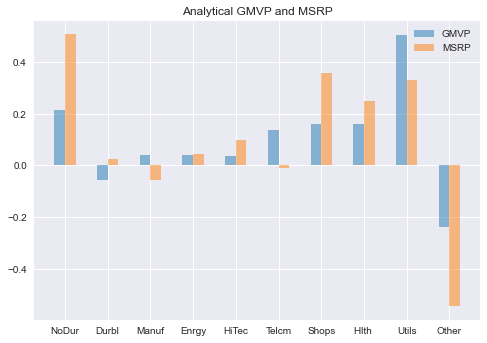

In [24]:
plt.style.use('seaborn')

ind = np.arange(len(ER))
plt.bar(ind, GMVP, width=0.25, alpha=0.5, color=cmap[0])
plt.bar(ind + 0.25, MSRP, width=0.25, alpha=0.5, color=cmap[1])
plt.xticks(ind + 0.25 / 2, ER.index)

plt.legend(['GMVP','MSRP'])
plt.title('Analytical GMVP and MSRP')
plt.show()


### Testing rolling window

---

In [15]:
egg_size = 2
egg = df_ER.copy().rolling(2)
type(egg)

pandas.core.window.rolling.Rolling

In [16]:
df_ER.head(3)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1980-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02,2.32,8.26,6.26,13.35,6.57,-2.85,0.57,-2.09,0.80,4.71
1980-03,-5.69,-7.20,-3.41,11.69,-4.44,-2.37,-5.70,-5.52,-4.25,-4.22


In [17]:
# egg 是 pandas 的 Rolling object，不能套用平常的 dataframe 方法
# 要對 rolling object 計算 (如取 mean, cov 等)才能轉成 dataframe
egg.mean().head(4)

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1980-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03,-1.685,0.530,1.425,12.520,1.065,-2.61,-2.565,-3.805,-1.725,0.245
1980-04,-7.530,-8.575,-8.175,-3.655,-9.155,-3.11,-7.805,-4.785,-6.065,-8.850


所以，上面 rolling 後第一筆資料是 1980-02 NoDur 的 NaN (NaN+2.32)/2=NaN  
第二筆資料的 -1.685 是 (2.32-5.69)/2 得出的

---

In [18]:
WSize = 60 # 以 60 個月 rolling
AvgER_rolling = df_ER.rolling(WSize).mean()
CovER_rolling = df_ER.rolling(WSize).cov()

Backtest_R = pd.DataFrame(index=df_R.index,columns=['GMVP','MSRP','EW'])

for d in df_ER.index:
    ER = AvgER_rolling.loc[d]
    S = CovER_rolling.loc[d]
    R = df_R.loc[d]
    Backtest_R.loc[d,'GMVP'] = pret(gmvp(S), R)
    Backtest_R.loc[d,'MSRP'] = pret(msrp(ER, S), R)

Backtest_R.loc[:,'EW'] = df_R.mean(axis=1) 
# 增加 equally weighted 的績效，recall df_R column 存放各產業的報酬

In [19]:
Backtest_R.head(61) # 因為 rolling window 是 60，所以前 60 筆資料是 NaN

,GMVP,MSRP,EW
Date,,,
1980-01,NaN,NaN,4.590
1980-02,NaN,NaN,-2.221
1980-03,NaN,NaN,-9.220
1980-04,NaN,NaN,4.829
1980-05,NaN,NaN,6.270
...,...,...,...
1984-09,NaN,NaN,0.353
1984-10,NaN,NaN,0.055
1984-11,NaN,NaN,-0.854


In [20]:
# 把 NaN 資料刪除
Backtest_R = Backtest_R.loc[ (df_R.index[0]+WSize): ] 
Backtest_R.head()

,GMVP,MSRP,EW
Date,,,
1985-01,0.689861,2.192756,8.121
1985-02,3.857239,3.875767,1.994
1985-03,7.552019,10.488243,0.507
1985-04,-2.159273,-1.184764,-0.599
1985-05,6.808913,6.777654,6.281


## Plot return

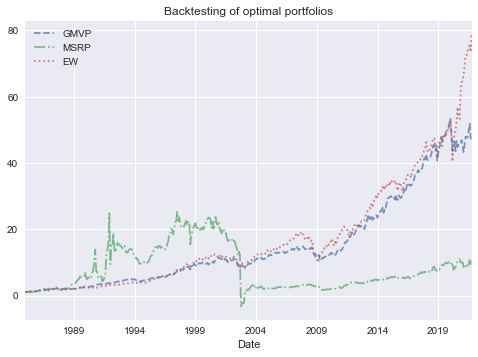

In [21]:
plt.style.use('seaborn')

CumRet = (1 + Backtest_R.divide(100)).cumprod()
CumRet['GMVP'].plot(alpha=0.75, linestyle="--")
CumRet['MSRP'].plot(alpha=0.75, linestyle="-.")
CumRet['EW'].plot(alpha=0.75, linestyle=":")

plt.legend()
plt.title('Backtesting of optimal portfolios')
plt.show()